# MACHINE LEARNING, LASSO

In [23]:
#Importing libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold

In [107]:
#Importing data
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
csv_file_path = '../outputdata/df_final.csv'
df_final = pd.read_csv(csv_file_path)
df_final.set_index('Unnamed: 0', inplace=True)
df_final.index.name = None
print(len(df_final))

19851


In [116]:
##Deleting observations with less than 20 m2 -> To avoid "non-appartments"
outliers_m2 = df_final[(df_final['m2'] < 20) | ((df_final['m2'] < 50) & (df_final['Boligtype'] == 'Landejendom'))]
#print(outliers_m2)
df_final = df_final.drop(outliers_m2.index)

In [118]:
df_final = df_final.dropna()
y = df_final['Price']
X = df_final.drop(columns=['Price', 'link', 'Schoolname', 'Postal code'])

#Creating dummies
X = pd.get_dummies(X, columns=['Municipiality', 'Boligtype', 'Energy-classification', 'Radon'], drop_first=True)

dummy_columns = X.select_dtypes(include=['bool']).columns
X[dummy_columns] = X[dummy_columns].astype(int)

In [122]:
X
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1) #The random_state works as a seed

#2
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.5, random_state=1)

In [87]:


lambdas = np.logspace(-4, 4, 12)
kfolds = KFold(n_splits=5)
folds = list(kfolds.split(X_dev, y_dev))

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=117))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)


C:\Users\matli\AppData\Local\Temp\ipykernel_66932\1040658962.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
C:\Users\matli\AppData\Local\Temp\ipykernel_66932\1040658962.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx]
C:\Users\matli\AppData\Local\Temp\ipykernel_66932\1040658962.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

In [92]:
lambdaCV

,0,1,2,3,4
0.000100,5.635275e+12,6.667443e+12,5.258990e+12,6.427729e+12,4.559493e+12
0.000534,5.635275e+12,6.667443e+12,5.258989e+12,6.427728e+12,4.559492e+12
0.002848,5.635271e+12,6.667441e+12,5.258986e+12,6.427726e+12,4.559488e+12
0.015199,5.635253e+12,6.667432e+12,5.258971e+12,6.427714e+12,4.559466e+12
0.081113,5.635158e+12,6.667382e+12,5.258889e+12,6.427652e+12,4.559346e+12
0.432876,5.634648e+12,6.667120e+12,5.258453e+12,6.427319e+12,4.558705e+12
2.310130,5.631946e+12,6.665729e+12,5.256122e+12,6.425547e+12,4.555308e+12
12.328467,5.618033e+12,6.658513e+12,5.243818e+12,6.416237e+12,4.537742e+12
65.793322,5.557182e+12,6.634132e+12,5.187877e+12,6.370646e+12,4.456261e+12
351.119173,5.398093e+12,6.623275e+12,4.941501e+12,6.192866e+12,4.230493e+12


In [125]:
from sklearn.model_selection import validation_curve

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=2)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
1873.817423    5.753954e+12
Name: Validation, dtype: float64


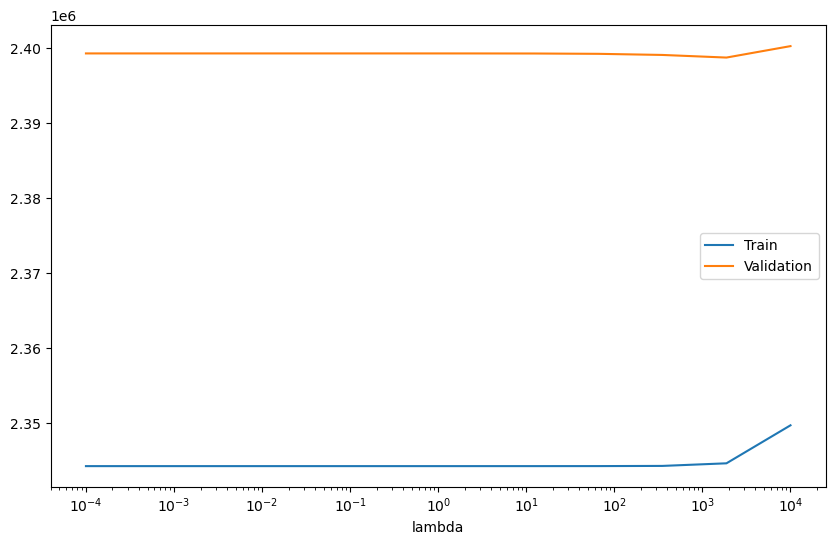

In [127]:
np.sqrt(mse_score).plot(logx=True, figsize=(10,6));